# Regression
Ein Modell wird nicht durch den Anwendungsbereich definiert,
sondern durch:

+ Eingabevariable (X)
+ Zielvariable (Y)
+ Loss-Funktion

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.BIWI_HEAD_POSE)


In [2]:
(path/'01').ls()
# enthält z. B.:
# frame_00116_rgb.jpg
# frame_00116_pose.txt

(#1000) [Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00269_rgb.jpg'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00416_rgb.jpg'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00466_pose.txt'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00193_rgb.jpg'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00303_pose.txt'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00189_rgb.jpg'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00290_rgb.jpg'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00148_rgb.jpg'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00149_pose.txt'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00497_rgb.jpg'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/frame_00447_pose.txt'),Path('/home/lukelo-tshakulongo/.fastai/data/biwi_head_pose/01/f

In [3]:
img_files = get_image_files(path)

def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('13/frame_00349_pose.txt')

Path('13/frame_00349_pose.txt')

(480, 640)


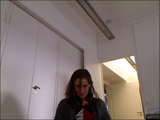

In [4]:
im = PILImage.create(img_files[0])
print(im.shape ) # (480, 640)
im.to_thumb(160)  # Miniaturbild

### Pose-Datei → Mittelpunkt berechnen
Wir wollen aus der Pose-Datei die 2D-Koordinaten des Gesichts berechnen:

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

# tensor([384.6370, 259.4787])

### DataBlock für Regression aufbauen
Wichtig:
* Nur fastai sorgt automatisch dafür, dass bei Daten-Augmentation Bild und Koordinaten synchron transformiert werden!

In [6]:
biwi = DataBlock(
  blocks=(ImageBlock, PointBlock),              # Bild + Punkt
  get_items=get_image_files,                    # alle Bilder finden
  get_y=get_ctr,                                # Label-Funktion
  splitter=FuncSplitter(lambda o: o.parent.name=='13'),  # Nur Person 13 für Validierung
  batch_tfms=[
    *aug_transforms(size=(240, 320)),           # Bild & Punkt transformieren
    Normalize.from_stats(*imagenet_stats)       # Normalisieren
  ]
)

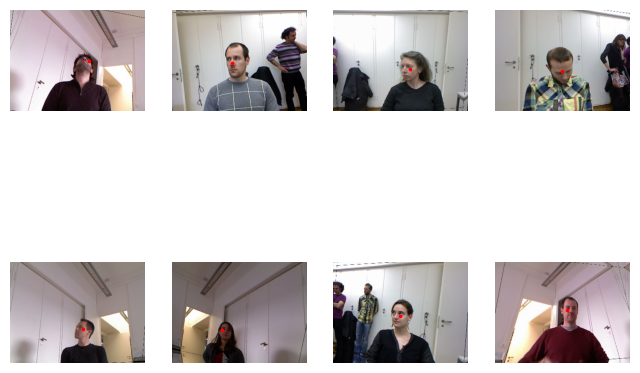

In [7]:
dls = biwi.dataloaders(path, bs=8)
dls.show_batch(max_n=9, figsize=(8,6))

In [8]:
xb, yb = dls.one_batch()
xb.shape     # torch.Size([64, 3, 240, 320])  → 64 Bilder, 3 Farbkanäle

torch.Size([8, 3, 240, 320])

In [9]:
yb.shape     # torch.Size([64, 1, 2])         → 64 Punkte, je 2 Koordinaten

torch.Size([8, 1, 2])

In [10]:
# Beispielziel
yb[0]


TensorPoint([[0.0114, 0.1319]], device='cuda:0')

### Training

+ Die vorhergesagten Koordinaten (Punkte) werden auf den Bereich –1 bis +1 skaliert

+ Das hilft, damit die Ausgaben nicht völlig unkontrolliert werden

In [11]:
# Wie funktioniert y_range?
# Die Sigmoid-Funktion bringt alles in den Bereich (0, 1)
# Mit * (hi - lo) + lo wird das dann auf z. B. (–1, 1) skaliert

# Intern nutzt FastAI diese Funktion:

def sigmoid_range(x, lo, hi): 
    return torch.sigmoid(x) * (hi - lo) + lo


In [12]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet18, y_range=(-1, 1)).to_fp16()


/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


### Loss-Funktion
+ MSELoss (Mean Squared Error):
+ Ideal für Regression

In [13]:
dls.loss_func

FlattenedLoss of MSELoss()

/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


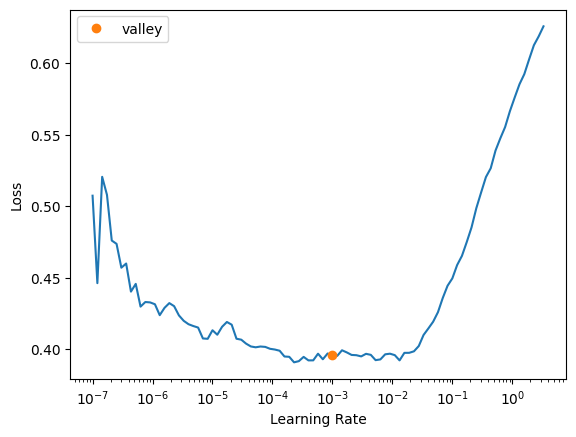

In [14]:
# 1. Lernrate finden:
lr = learn.lr_find()


In [15]:
learn.fit_one_cycle(5, lr.valley)



epoch,train_loss,valid_loss,time
0,0.033794,0.005809,01:49
1,0.013204,0.004049,01:49
2,0.008169,0.000729,01:50
3,0.007008,0.002138,01:45
4,0.005342,0.000735,01:46


#### Wie gut ist das?

In [ ]:
import math
math.sqrt(0.000735) 
# Der durchschnittliche Fehler bei der Position liegt bei 1 % der Bildgröße – ziemlich gut!

0.027110883423451918

#### Ergebnisse ansehen

/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/lukelo-tshakulongo/Bankoko/φ-σ-Ω/Computer Science/Code/Mulandu/DLConcepts/venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


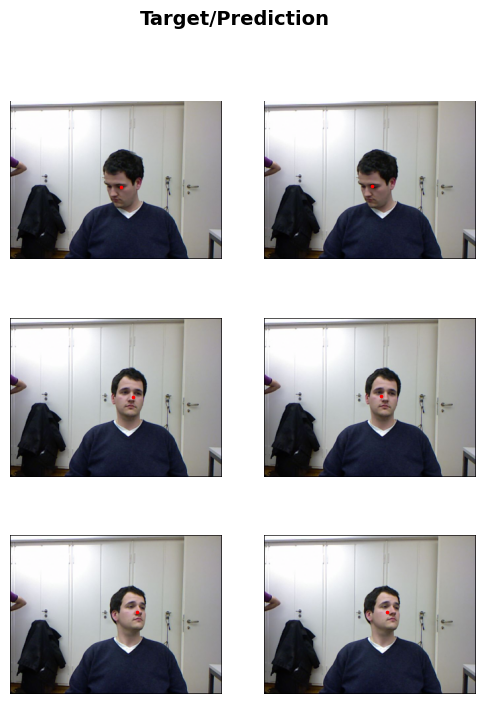

In [18]:
# Linke Seite: Wahre Position des Gesichts
# Rechte Seite: Vorhersage des Modells

learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))